# Import the Dataset

In this notebook a 3D analysis of the -- is demonstated. In addition to the usuall model parameters so called 'nuisance parameters' are fitted which account for any systematical uncertainties. These sysetmatical uncertainties are assumed to be due a missmodelling of the hardronic background. 

The nuisance parameters are correlated so they can only eliminate the systemtic uncertainties but not the uncorrelated statistical uncertainicies.  

The notebook is structed as follows:

- Setting up the correlation of the nuisacane parameters
- Fitting the model and the nuisance parameters to the data
- Compare the results to the standard 3D fit
- Save the fitted dataset

Differences to the basic tutorial:
- No need to define the e range in which the nuisance parameters are fitted, but the `nuisance_mask` is based on the sysamplitude (put 0, where we dont want to fit) 

In [1]:
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import yaml
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from regions import CircleSkyRegion

import sys

sys.path.append(
    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
)
from my_dataset_maps_19 import MapDatasetNuisance
from  my_fit_19 import Fit

In [2]:
source = 'Crab' #Crab 'GC'

In [4]:
dataset_standard = MapDataset.read(f'{source}/stacked.fits')

if source == 'NGC253':
    width=5
elif source == 'Crab':
    width=8
dataset_standard = dataset_standard.cutout(
    position=dataset_standard.geoms["geom"].center_skydir, width=width * u.deg
)

with open(f'{source}/standard_model.yml', 'r') as file:
    standard_model = yaml.full_load(file)
models = Models.from_dict(standard_model)
# gets somehow read into as an int which causes problems when printing with precison
models.parameters['reference'].error = float(models.parameters['reference'].error)

with open(f'{source}/standard_bgmodel.yml', 'r') as file:
    standard_bg_model = yaml.full_load(file)

bkg_model = FoVBackgroundModel(dataset_name = dataset_standard.name)

models.append(bkg_model)
dataset_standard.models =models

In [6]:
print(" with nuisance")
print("(without nuisance)")
for  p_stand in dataset_standard.models.parameters :
    print()
    print('='*50)
    print(p_stand.name)
    print('-'*50)
    print('({:.3} pm {:.3})'.format(p_stand.value, p_stand.error) )

 with nuisance
(without nuisance)

amplitude
--------------------------------------------------
(3.7e-11 pm 2.83e-13)

reference
--------------------------------------------------
(1.0 pm 0.0)

alpha
--------------------------------------------------
(2.51 pm 0.0183)

beta
--------------------------------------------------
(0.103 pm 0.00912)

lon_0
--------------------------------------------------
(83.6 pm 0.000635)

lat_0
--------------------------------------------------
(22.0 pm 0.000873)

sigma
--------------------------------------------------
(0.0192 pm 0.00427)

e
--------------------------------------------------


ValueError: Precision not allowed in integer format specifier

The first two energybins of the dataset are not fitted well ...

/home/woody/caph/mppi062h/software/anaconda/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


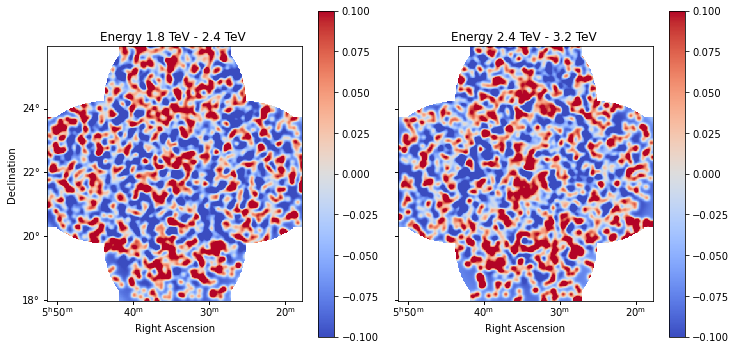

In [8]:
res_standard = (
    dataset_standard.residuals("diff/sqrt(model)")
    .slice_by_idx(dict(energy=slice(10, 12)))
    .smooth(0.07 * u.deg)
)
vmax = np.max(np.abs(res_standard.data))
res_standard.plot_grid(add_cbar=1, vmax=vmax, vmin=-vmax, cmap="coolwarm");

## Nuisance Parameters

Here, two things are used to save computation time:
- The nuisance parameters are computed only within the first two energybins of the analysis (index 4 and 5) exemplary to save computation time. This approximation is fine since the systematic uncertainites are known to be the largest at the smaller energies. The complete assumed systematic errors are read, but only where they are larger than zero the nuisance parameters are fitted. The meaning of `sys_amplitude` is explained in the following and for now only used for the masking.
- The nuisance parameter have a larger binsize than the counts cube. The downsampling factor `downsampling_factor` denotes that. This way, one nuisance parameter acts on multiple neighbor bins and the systematic uncertainty is averaged over them. The geometry of this downsampled nuisance parameter cube is saved in `dataset.geoms['geom_down']`.




The `nuisance_mask` describes where in the dataset the nuisance parameters are evaulated. It has the same geometry as `dataset.geoms['geom_down']`. 

In [9]:
dataset_standard.counts.geom

WcsGeom

	axes       : ['lon', 'lat', 'energy']
	shape      : (400, 400, 24)
	ndim       : 3
	frame      : icrs
	projection : CAR
	center     : 83.6 deg, 22.0 deg
	width      : 8.0 deg x 8.0 deg
	wcs ref    : 83.6 deg, 22.0 deg

In [11]:
downsampling_factor = 100
# read the real sys amplitude here ... 
sysamplitude = abs(np.loadtxt(f'{source}/sysamplitude_std.txt')) # this is because the sys is now in units of % of bkg

nuisance_mask_helper = np.array(sysamplitude)>0
print('nui_mask:',nuisance_mask_helper)
nuisance_mask = Map.from_geom(dataset_standard.geoms["geom"].downsample(downsampling_factor),
                             dtype=bool)
for e, n in enumerate(nuisance_mask_helper):
    nuisance_mask.data[e,:,:] = n

nui_mask: [False False False False False False  True  True  True  True  True False
 False  True False False False  True False False False False False False]


The total amount of nuisance parameters in the dataset can now be computed (defined as `ndim_3D_nui`). The number of spatial and spectral dimensions of the nuisance parameter cube is defined as `ndim_spatial_nui` and `ndim_spectral_nui` since it is needed for the computation of the correlation matrix. Note that here the FoV is expected to be squared. 
The nuisance parameters are defined with their initial value set to `0`.

In [12]:
ndim_3D_nui = sum(nuisance_mask.data.flatten())
ndim_spatial_nui_1D = (
    dataset_standard.geoms["geom"]
    .downsample(downsampling_factor)
    .data_shape[1]
)
ndim_spatial_nui = ndim_spatial_nui_1D ** 2
ndim_spectral_nui = len(np.where(nuisance_mask_helper)[0])

print(f"Number of nuisance parameters: {ndim_3D_nui}")
print(
    "at energy: {:.2} : {:.2}".format(
        dataset_standard.geoms["geom"].axes[0].edges[np.where(nuisance_mask_helper)[0][0]],
        dataset_standard.geoms["geom"].axes[0].edges[np.where(nuisance_mask_helper)[0][-1]+1 ],
    )
)

Nuisance_parameters = Parameters(
    [
        Parameter(name="db" + str(i), value=0, frozen=False)
        for i in range(ndim_3D_nui)
    ]
)

Number of nuisance parameters: 112
at energy: 0.56 TeV : 1.8e+01 TeV


## Correlation of Nuisance Parameters

The Gaussian correlation matrix is the kronecker product of the spatial $K_{ij}$ and the spectral correlation matrix $K_{e}$: \
$ K_{ije} = K_{e} \cdot K_{ij} $

The spatial correlation matrix is defined as follows:

$K_{ij} = \exp \left( \frac{ -  (r_i - r_j ) ^2} {2\cdot l_{corr}^2}    \right)$,\
where $l_{corr}$ describes the spatial correlation length. Note that the correlation amplitude in the spatial correlation matrix is set to $1$. This is due to the fact, that we assume in the first order a uniformly distributed systematic uncertainty over the FoV. The correaltion amplitude was evaluated over the summed up FoV for each of the energybins and is therefore used in the spectral correlation desciption only.

The spectral correaltion matrix is:

$K_{s} = \sigma_s $, \
where $\sigma_s$ is the correlation amplitude in the spectral bin $s$. Note that here the correlation is in fact not Gaussian and there is no correlation between the energy bins. The correaltion is intrinsically included in the way the spectral correlation amplitude is defined. 


Therefor for the Gaussian correlation matrix $K_{ije}$ of the nuisance parameter one needs two parameters:
- `l_corr`: the spatial correlation length in deg. For instance, a Fourier transformation of the residual map of the standard analysis can be used to estimate the correlation length. Generally, it is important to choose a correaltion length greater than the bin size of the counts cube to avoid fitting the nuisance parameters without any correlation which can lead to overfitting the data. 
- `sysamplitude`: list of correlation amplitudes for the different energybins. The strength of the systematics can be estimated of the spectral residual points when taking only the OFF regions of all runs into account. Here, these obtained values are divided by the amount of spatial bins they were computed for.   

In [13]:
l_corr = 0.8
sysamplitude /=   ndim_spatial_nui
sysamplitude = np.array(sysamplitude)

The `sysamplitude` can also be expressed in terms of expected counts due to systematic uncertainties in one energy bin and in terms of percent of the background counts. 

In [14]:
bg = (
    dataset_standard.background
    .data.sum(axis=2)
    .sum(axis=1)
)[nuisance_mask_helper]
print(bg)
print("Estimated systematic uncertainty: ")
print()
print("Ebin                      [Counts]               [% BG]")
e =0 
for ii in np.arange(len(sysamplitude)):
    if sysamplitude[ii] > 0.0:
        e_start, e_end = (
            dataset_standard.geoms["geom"].axes[0].edges[ ii],
            dataset_standard.geoms["geom"].axes[0].edges[ ii + 1],
        )

        sys_counts = sysamplitude[ii] * ndim_spatial_nui * np.sqrt(bg[e])
        sys_percent = sys_counts / bg[e]

        print(
            "{:.2} : {:.2} TeV            {:.3}               {:.3}  ".format(
                e_start.value, e_end.value, sys_counts, sys_percent * 100
            )
        )
        e+=1 

[45500.54   88869.39   71121.18   57874.85   41902.61   14730.158
  3740.2524]
Estimated systematic uncertainty: 

Ebin                      [Counts]               [% BG]
0.56 : 0.75 TeV            1.36e+03               2.98  
0.75 : 1.0 TeV            2.95e+03               3.32  
1.0 : 1.3 TeV            6.67e+03               9.37  
1.3 : 1.8 TeV            1.49e+03               2.58  
1.8 : 2.4 TeV            1.18e+03               2.82  
4.2 : 5.6 TeV            1.3e+03               8.83  
1.3e+01 : 1.8e+01 TeV            2.39e+02               6.38  


The spatial correlation matrix is computed with two helper maps to compute the separation angle between two spatial bins. Afterwards, the systematic amplitude is set as the diagonal of the spectral correlation matrix and the kroneker product of the two is returned as the overall correlation matrix. 

In [15]:
geom_down = nuisance_mask.geom
helper_map = Map.from_geom(geom_down).slice_by_idx(dict(energy=slice(0, 1)))
helper_map2 = helper_map.copy()


def compute_K_matrix(l_deg):
    corr_matrix_spatial = np.identity(ndim_spatial_nui)
    for b_0 in range(ndim_spatial_nui_1D):
        for l_0 in range(ndim_spatial_nui_1D):
            i = b_0 * ndim_spatial_nui_1D + l_0
            C = SkyCoord(
                helper_map.geom.pix_to_coord((l_0, b_0, 0))[0],
                helper_map.geom.pix_to_coord((l_0, b_0, 0))[1],
                frame=geom_down.frame,
            )
            helper_map.data[0, :, :] = C.separation(
                geom_down.to_image().get_coord().skycoord
            ).value
            helper_map2.data = np.zeros(ndim_spatial_nui_1D ** 2).reshape(
                helper_map2.geom.data_shape
            )
            helper_map2.data[0, :, :] = np.exp(
                -0.5 * helper_map.data[0, :, :] ** 2 / l_deg ** 2
            )
            corr_matrix_spatial[i, :] = helper_map2.data.flatten()

    corr_matrix_spectral = np.identity(ndim_spectral_nui)
    for e in range((ndim_spectral_nui)):
        corr_matrix_spectral[e, e] = sysamplitude[nuisance_mask_helper][e] ** 2
    return np.kron(corr_matrix_spectral, corr_matrix_spatial)

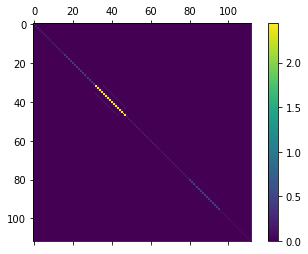

In [16]:
correlation_matrix = compute_K_matrix(l_corr)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlation_matrix)  # interpolation='nearest')
fig.colorbar(cax);

# Initiate the MapDatasetNuisance

The MapDatasetNuisance class takes in addition to the MapDataset class:
- `inv_corr_matrix`: The inverse of the correlation matrix 
- ` N_parameters`: The nuisance parameters
- `nuisance_mask`: Mask to help evaluating the nuisance parameters in the background prediction

In [17]:
dataset_N = MapDatasetNuisance(
    background=dataset_standard.background,
    exposure=dataset_standard.exposure,
    psf=dataset_standard.psf,
    edisp=dataset_standard.edisp,
    mask_fit=dataset_standard.mask_fit,
    mask_safe=dataset_standard.mask_safe,
    counts=dataset_standard.counts,
    inv_corr_matrix=np.linalg.inv(correlation_matrix),
    N_parameters=Nuisance_parameters,
    nuisance_mask=nuisance_mask,
)

bkg_model = FoVBackgroundModel(dataset_name=dataset_N.name)
bkg_model.parameters["tilt"].frozen = False
models_N = models.copy()
models_N.append(bkg_model)
dataset_N.models = models_N
print(dataset_N)

MapDatasetNuisance
------------------

  Name                            : M1S7O9Oy 

  Total counts                    : 437824 
  Total background counts         : 407377.44
  Total excess counts             : 30446.56

  Predicted counts                : 439387.13
  Predicted background counts     : 407377.33
  Predicted excess counts         : 32009.80

  Exposure min                    : 9.22e-02 m2 s
  Exposure max                    : 2.25e+11 m2 s

  Number of total bins            : 3840000 
  Number of fit bins              : 2390256 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 1041327.09

  Number of models                : 2 
  Number of parameters            : 12
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : main source
    Datasets names            : None
    Spectral model type       : LogParabolaSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model type 

## Running the Fit

In [ ]:
%%time
fit_N = Fit(store_trace=False)
result_N = fit_N.run([dataset_N])

len parameters: 124


The method `N_map()` is a map in the origial geometry with the nuisance parameters as the data. It is used in npred_background() and visualises the best fit nuisance parameters.

In [ ]:
i_start , i_end = np.where(nuisance_mask_helper)[0][0] ,np.where(nuisance_mask_helper)[0][-1]
vmax = np.max(np.abs(dataset_N.N_map().data))
dataset_N.N_map().slice_by_idx(dict(
    energy=slice(int(i_start) , int(i_end)+1))).plot_grid(
    add_cbar=1, vmax=vmax, vmin=-vmax
);

## Comparison to Standard Analysis

The spectral residual points show again how especially the first two energybins are not fitted well

In [ ]:
kwargs_spectral = dict()
kwargs_spectral["region"] = CircleSkyRegion(
    dataset_standard.geoms["geom"].center_skydir, radius=3 * u.deg
)
kwargs_spectral["method"] = "diff/sqrt(model)"
dataset_standard.plot_residuals(kwargs_spectral=kwargs_spectral);

After including the nuisance parameters the model description is much better in the first two energy bins. This indicates that the method worked and has improved out analysis.

In [ ]:
res_N = (
    dataset_N.residuals("diff/sqrt(model)")
    .slice_by_idx(dict(energy=slice(4, 6)))
    .smooth(0.1 * u.deg)
)
vmax = np.max(np.abs(res_standard.data))
res_N.plot_grid(add_cbar=1, vmax=vmax, vmin=-vmax, cmap="coolwarm");

In [ ]:
dataset_N.plot_residuals(kwargs_spectral=kwargs_spectral);

Her a comparison of the distribution of the significance maps in the first two energy bins is shown. With the nuisance parameters the mean of the distribution $\mu$ got closer to zero and the standard deviation $\sigma$ is closer to the expected $1$.

In [ ]:
res_standard = (
    dataset_standard.residuals("diff/sqrt(model)")
    .slice_by_idx(dict(energy=slice(i_start, i_end)))
    .data.flatten()
)
res_N = (
    dataset_N.residuals("diff/sqrt(model)")
    .slice_by_idx(dict(energy=slice(i_start, i_end)))
    .data.flatten()
)

_, bins, _ = plt.hist(
    res_standard,
    bins=50,
    alpha=0.4,
    label="Standard: \n$\mu$ = {:.3} \n$\sigma$ = {:.3}".format(
        np.mean(res_standard), np.std(res_standard)
    ),
)
plt.hist(
    res_N,
    bins=bins,
    alpha=0.4,
    label="Nuisance: \n$\mu$ = {:.3} \n$\sigma$ = {:.3}".format(
        np.mean(res_N), np.std(res_N)
    ),
)
plt.yscale("log")
plt.legend()
plt.xlabel("Significance")
plt.ylabel("Amount");

## Comparsion of the erros of the best fit model parameters

The model errors of the Nuisance dataset have for now to be set by hand. 

In [ ]:
import my_dataset_core_19, my_fit_19
parameters  = Parameters.from_stack([dataset_N.N_parameters,dataset_N.models.parameters])
kwargs = fit_N.covariance_opts.copy()
kwargs["minuit"] = fit_N.minuit
backend = kwargs.pop("backend", fit_N.backend)
compute = my_fit_19.registry.get("covariance", backend)

with parameters.restore_status():

    factor_matrix, info = compute(
        parameters=parameters, function=dataset_N.stat_sum, **kwargs
    )


covariance = Covariance.from_factor_matrix(
                parameters=parameters, matrix=factor_matrix
            )
for par in dataset_N.models.parameters:
    pars = Parameters([par])
    variance = covariance.get_subcovariance(pars)
    par.error = np.sqrt(variance)

Due to the larger parameter space, the error bars of the parameters with the nuisance parameters are larger than from the standard analysis.

In [ ]:
print(" with nuisance")
print("(without nuisance)")
for p_N, p_stand in zip(dataset_N.models.parameters,dataset_standard.models.parameters ):
    print()
    print('='*50)
    print(p_N.name, p_stand.name)
    print('-'*50)
    print(' {:.3} pm {:.3}'.format(p_N.value, p_N.error) )    
    print('({:.3} pm {:.3})'.format(p_stand.value, p_stand.error) )


## Write and Read the MapDatasetNuisance

In [ ]:
import yaml
# writing the fitted MapDatasetNuisance ...
outputfile = source
dataset_N.write(outputfile+'/nui_dataset.fits', overwrite = True)
with open(outputfile+'/nui_par.yml', 'w') as outfile:
        yaml.dump(dataset_N.N_parameters.to_dict(), outfile, default_flow_style=False)
with open(outputfile+'/nui_model.yml', 'w') as outfile:
        yaml.dump(dataset_N.models.to_dict(), outfile, default_flow_style=False)
with open(outputfile+'/nui_bgmodel.yml', 'w') as outfile:
        yaml.dump(dataset_N.background_model.to_dict(), outfile, default_flow_style=False)